# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

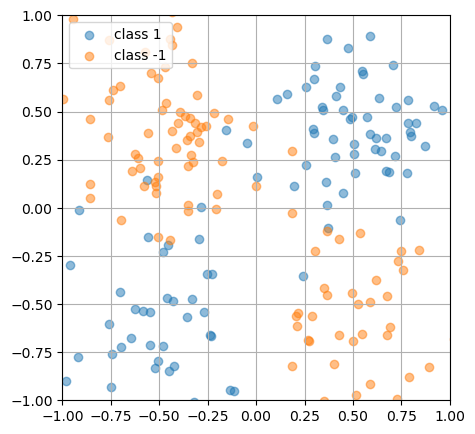

In [46]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian and linear kernels

Implement the method 'kernel' of the classes RBF and Linear below. The RBF kernel which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/\sigma^2)$. (The fastest solution does not use any for loop!)

In [47]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        p,d = X.shape
        n,d = Y.shape
        X = np.reshape(X,(p,1,d))
        Y = np.reshape(Y,(1,n,d))
        D = np.sum((X - Y)**2, axis = 2)
        return  np.exp(-D/(self.sigma**2)) ## Matrix of shape NxM

In [48]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.dot(X,Y.T)## Matrix of shape NxM


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [49]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y) #Number of points
        rbf = RBF() #definition of an object RBF
        kernel = rbf.kernel(X,X) #Calculations of the RBF kernel associated to X

        # Lagrange dual problem
        def loss(alpha):
            return 1/2*alpha.T @ kernel @ alpha - np.dot(alpha,y)#'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return kernel @ alpha - y# '''----------------partial derivative of the dual loss wrt alpha -----------------'''

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        Diag = np.concatenate((-np.diag(y), np.diag(y)))
        f1 = np.zeros(N)
        f2 = np.ones(N)*self.C
        f = np.concatenate((f1,f2))
        fun_eq = lambda alpha: np.sum(alpha) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha: np.ones(alpha.shape)  #'''----------------jacobian wrt alpha of the equality constraint------------------'''
        fun_ineq = lambda alpha: f - Diag @ alpha  # '''---------------function defining the inequality constraint-------------------'''     
        jac_ineq = lambda alpha: -Diag  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''

        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        self.margin_points = X[self.alpha == self.C] #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''

        e = X[np.where((self.alpha > 1e-10) & (self.alpha < self.C))]
        ind = y[np.where((self.alpha > 1e-10) & (self.alpha < self.C))]
        i = 0
        self.b = ind[i] - (self.alpha @ rbf.kernel(X, e))[i]
        self.norm_f = self.alpha @ kernel @ self.alpha # '''------------------------RKHS norm of the function f ------------------------------'''

        self.support = X

    ### Implementation of the separating function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return  self.alpha @ self.kernel(self.support,x)

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

Number of support vectors = 100


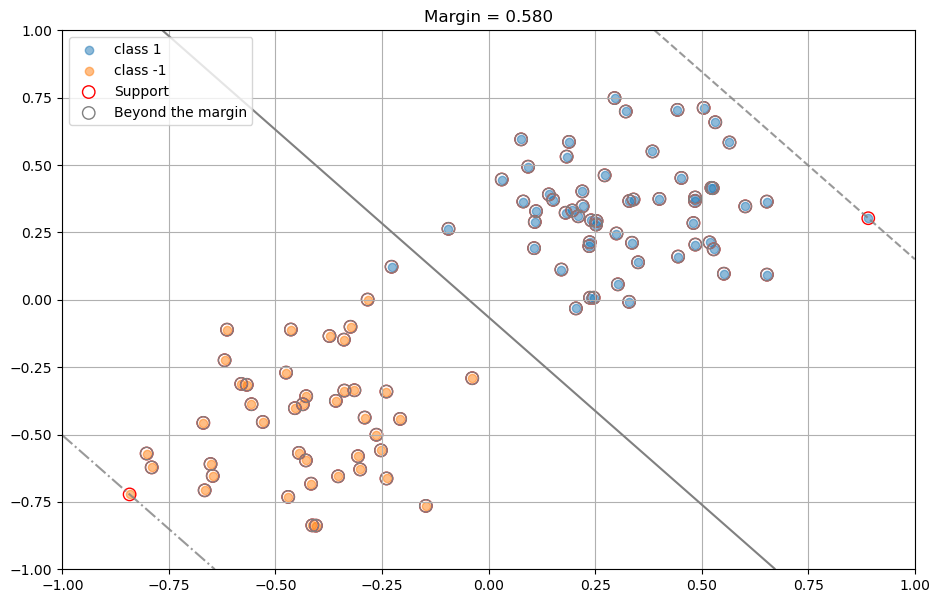

In [59]:
C= 1e0 #provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian classifier

Number of support vectors = 100


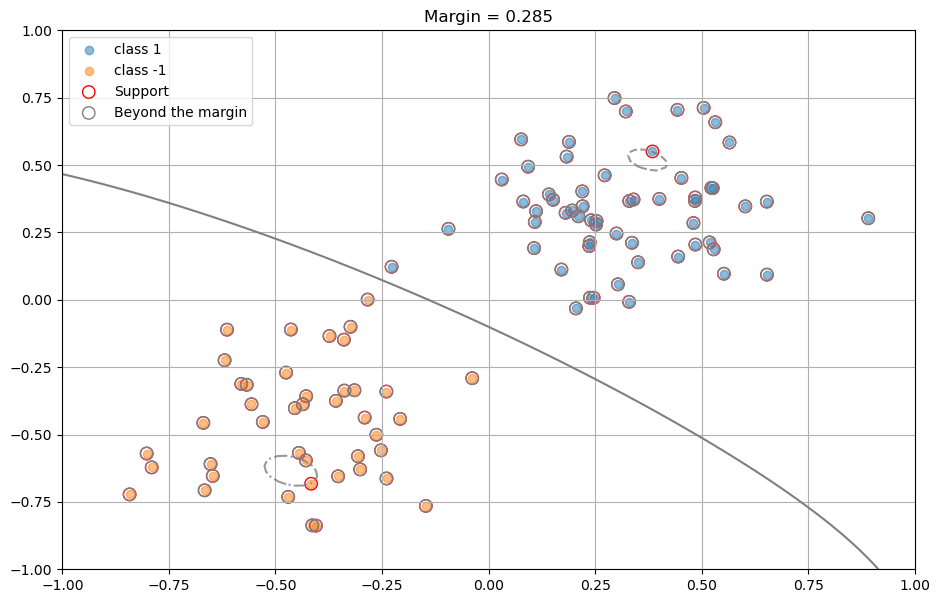

In [564]:
sigma = 1#TODO: provide a reasonalbe value
C= 1e1#TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 2
#### Linear SVM

Number of support vectors = 100


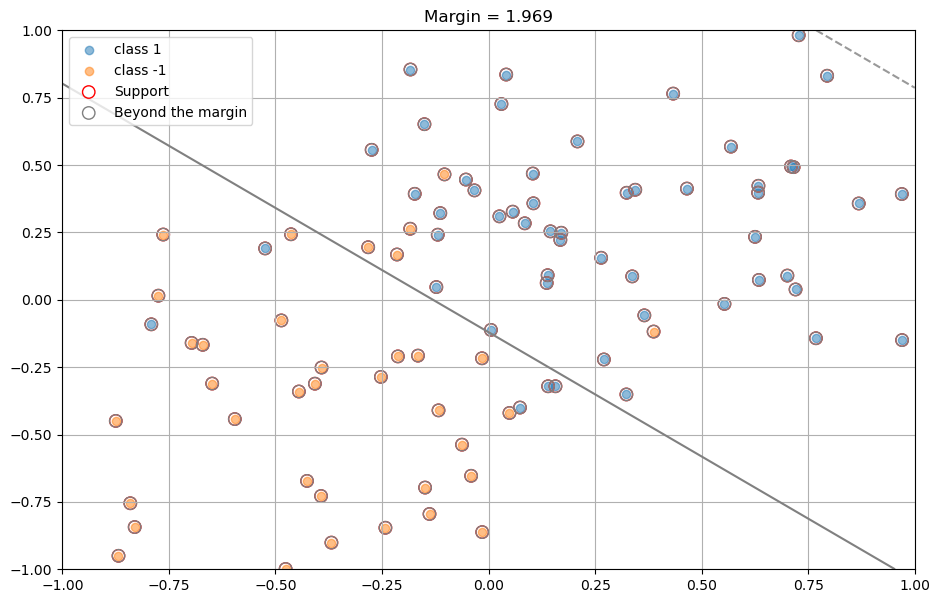

In [8]:
C= 0.1#TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 100


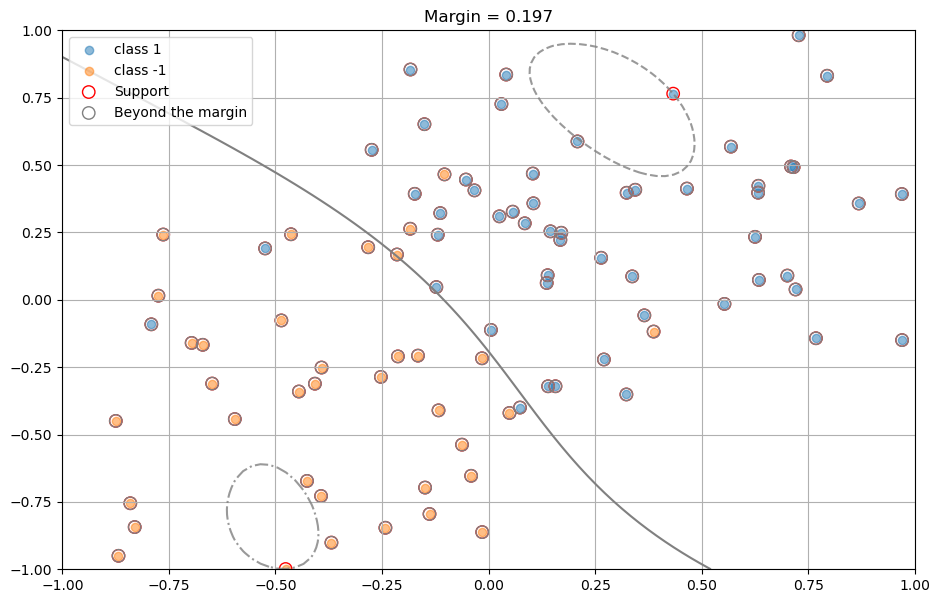

In [565]:
sigma = 1#TODO: provide a reasonalbe value
C= 1e1#TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 3
#### Linear SVM

Number of support vectors = 200


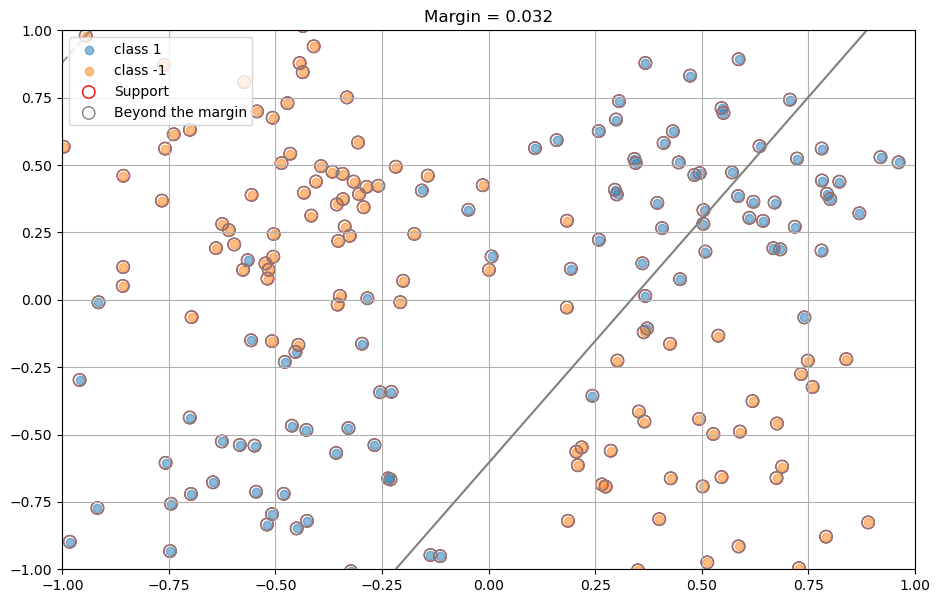

In [10]:
C= 1e1#TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 200


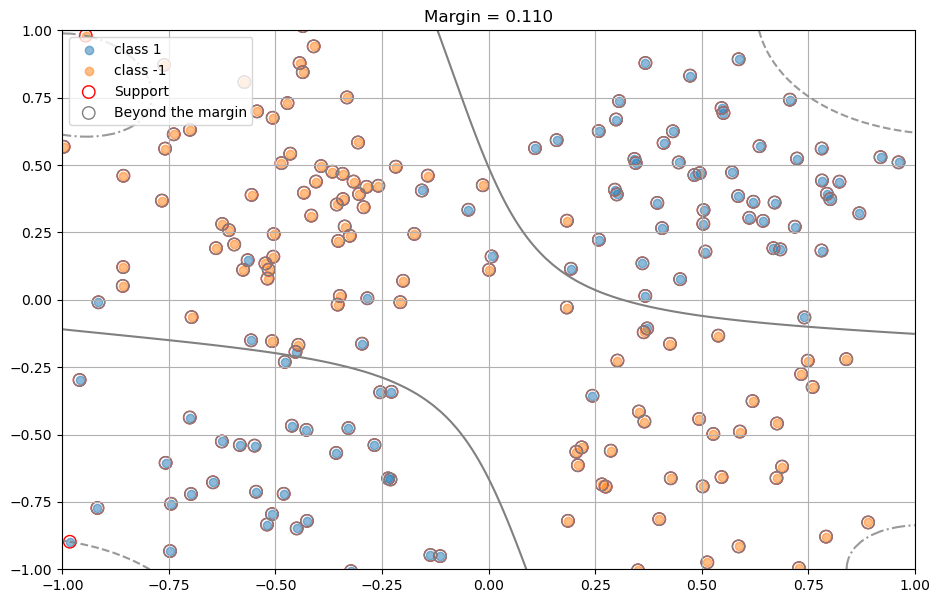

In [11]:
sigma = 1#TODO: provide a reasonalbe value
C= 1 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

# Kernel Regression

## Loading the data

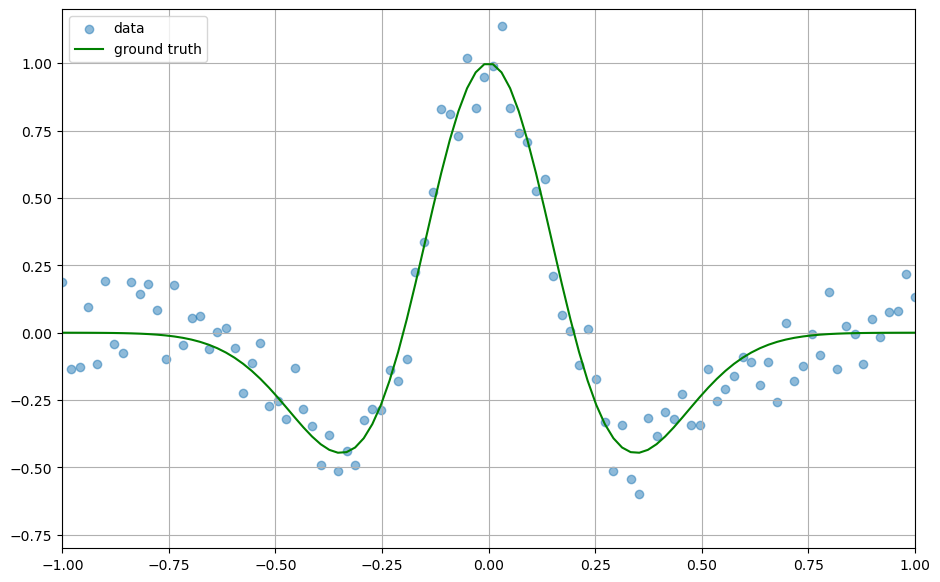

In [12]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])

## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [6]:
class KernelRR:
    
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'

    def fit(self, X, y):
        self.support = X
        N,_ = X.shape #Number of samples
        K = self.kernel(X,X)
        K_ridge = K + np.eye(N)*self.lmbda
        inv_den = np.linalg.solve(K_ridge,np.ones(N))
        inv_num = np.linalg.solve(K_ridge,y)
        self.b = (N + np.sum(K @ inv_num) - np.sum(y))/(np.sum(K @ inv_den))
        self.alpha = np.linalg.solve(K_ridge,y - self.b*np.ones(N))

    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.alpha @ self.kernel(self.support,x)

    def predict(self, X):
        return self.regression_function(X) + self.b

class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'

    def fit(self, X, y):
        # X is an array of size N x d
        # y is an array of size N x q (if it is q x N, reshape it so it becomes N x q)
        self.support = X
        N,_ = X.shape #Number of samples
        K = self.kernel(X,X)
        K_ridge = K + np.eye(N)*self.lmbda
        inv_den = np.linalg.solve(K_ridge,np.ones(N))
        inv_num = np.linalg.solve(K_ridge,y)
        self.b = (N + np.sum(K @ inv_num) - np.sum(y))/(np.sum(K @ inv_den))
        self.alpha = np.linalg.solve(K_ridge,y - self.b*np.ones(N))

    ### Implementation of the separating function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N x q
        return self.kernel(x,self.support) @ self.alpha

    def predict(self, X):
        return self.regression_function(X)+np.expand_dims(self.b,axis=0)

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

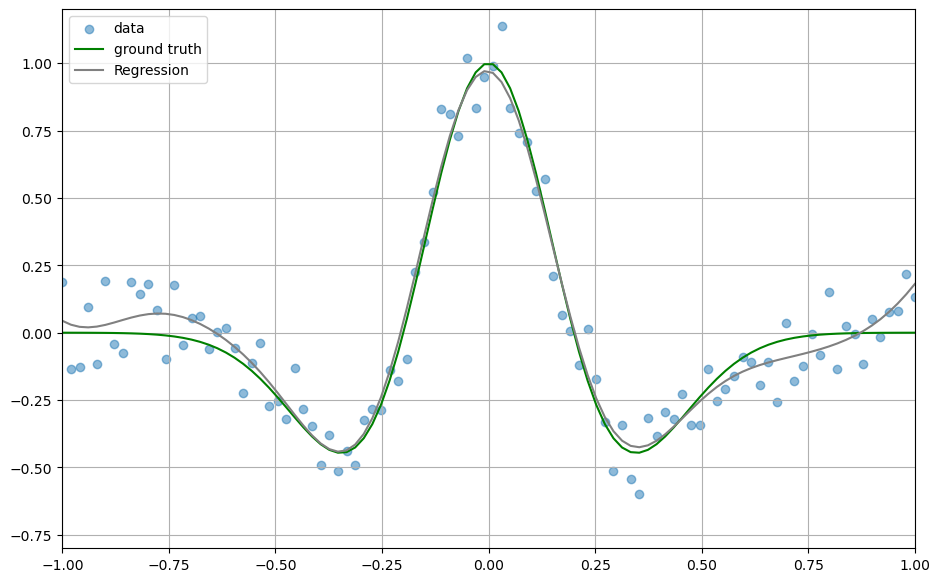

In [14]:
sigma = 0.2 #TODO: provide a reasonable value
lmbda= 1e-1 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
train_set_x = train_set['x'].reshape(train_set['x'].shape[0],1)
train_set_y = train_set['y'].reshape(train_set['y'].shape[0], 1)
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [38]:
class kernelPCA:
    
    def __init__(self,kernel, r=2):
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
        self.Ku = None
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        kern = self.kernel(X,X)
        # N = X.shape[0]
        # K = np.empty((N,N))
        # for i in range(X.shape[0]):
        #     for j in range(X.shape[0]):
        #         K[i,j] = kern[i,j] - 1/N*(np.sum(kern[i]) + np.sum(kern[j])) + 1/N**2*np.sum(kern)
        # self.Ku = K
        # Or a smarter way
        C=np.eye(kern.shape[0])-np.ones(kern.shape)/kern.shape[0] # centering
        self.Ku=C.dot(kern).dot(C)
        self.lmbda, self.alpha = np.linalg.eig(self.Ku)
        self.lmbda = self.lmbda[1: 1 + self.r].real
        self.alpha = self.alpha[:,1: 1 + self.r].real #already normalized to unity
        #Failure
        ###
        # #Constraints
        # def fun_eq(alpha):
        #     # alpha_1 = alpha.reshape(self.r,N)
        #     # alpha_2 = alpha.reshape(self.r,N).T
        #     return (alpha.reshape(self.r,N) @ alpha.reshape(self.r,N).T - np.eye(self.r)).flatten()

        # def jac_eq(alpha):
        #     Jac = np.zeros((self.r**2, N*self.r))
        #     for i in range(self.r):
        #         for j in range(self.r):
        #             if (i == j):
        #                 Jac[i*self.r + i][i*N : (i + 1)*N] = 2*alpha[self.r*i : i*self.r + N]
        #             else:
        #                 Jac[i*self.r + j][i*N : (i + 1)*N] = alpha[N : 2*N]
        #                 Jac[i*self.r + j][j*N : (j + 1)*N] = alpha[ : N]
        #     return Jac

        # #Objective function
        # def loss(alpha):
        #     K_diag = np.kron(np.eye(self.r,dtype=int),K)
        #     #print(1/2*alpha.T @ K_diag @ alpha)
        #     return 1/2*alpha.T @ K_diag @ alpha

        # constraints = ({'type' : 'eq', 'fun' : fun_eq, 'jac' : jac_eq})
        # optRes = optimize.minimize(fun = loss,
        #                     x0=1/2*np.ones(N*self.r),
        #                     method='SLSQP',
        #                     constraints=constraints)
        #self.alpha = optRes.x

    ###
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N x r
        M = x.shape[0]
        N = self.support.shape[0]
        Z = np.empty((M, self.r))
        K = self.kernel(self.support,x)
        print(self.support.shape)
        for i in range(self.r):
            Z[:,i] = self.alpha.T[i] @ self.K - 1/N*np.sum(self.alpha.T[i])*np.sum(K,axis = 0)
        return Z

### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

(100, 2)


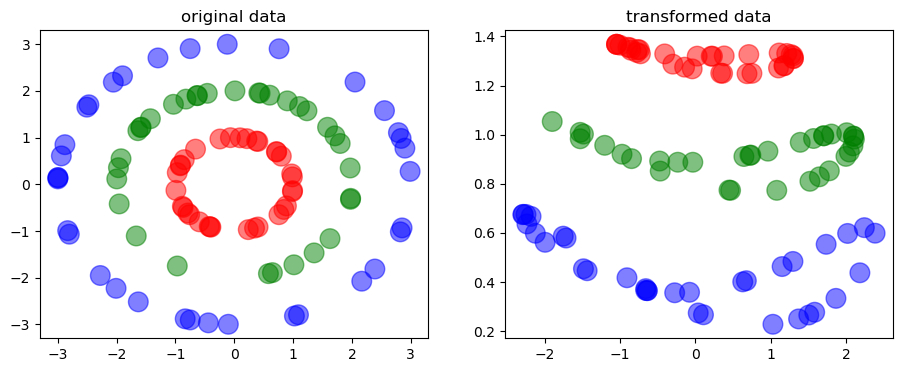

In [45]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']
sigma = 4
kernel = RBF(sigma).kernel
pca = kernelPCA(kernel, r=2)
pca.compute_PCA(train_set['x'])
pca_components = pca.transform(train_set['x'])


fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(train_set['x'], train_set['y'], ax[0], title='original data')
scatter_label_points(pca_components,train_set['y'], ax[1], title= 'transformed data')

In [40]:
data_transform

array([[ 1.40740279e-01, -5.25382111e-02, -4.11850746e-02],
       [ 3.62187240e-02, -1.22730731e-01, -4.73025978e-02],
       [ 1.55745662e-01,  4.27217913e-02, -4.28784795e-02],
       [ 1.57262174e-01, -2.35815257e-03, -4.11577098e-02],
       [-5.25276675e-02, -1.04372991e-01, -4.92600978e-02],
       [-7.46357601e-03, -1.21317130e-01, -4.88401918e-02],
       [ 1.44866330e-01, -4.45481576e-02, -4.10214598e-02],
       [ 1.02242590e-01, -9.63467854e-02, -4.34912540e-02],
       [ 1.56847656e-01, -5.33420062e-03, -4.10977874e-02],
       [ 1.02192249e-01,  1.28113581e-01, -4.95489070e-02],
       [-1.21130733e-01,  2.11722417e-02, -4.66339316e-02],
       [ 1.46149246e-01,  7.29706238e-02, -4.47968888e-02],
       [ 1.52852545e-01,  5.46457079e-02, -4.35675592e-02],
       [ 8.92434796e-02,  1.36743806e-01, -5.03993555e-02],
       [ 8.82658124e-02, -1.05462627e-01, -4.43919327e-02],
       [ 3.30289134e-02, -1.23089614e-01, -4.74471772e-02],
       [ 5.46776268e-04,  1.54709083e-01

# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [65]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)

    def fit(self,train):

        
    def denoise(self,test):

        return 

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

In [11]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']


dim_pca =80
lmbda = 10.
sigma_encoder =8.
sigma_decoder =.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(data['train'])
pred = denoiser.denoise(data['test'])

plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)